# QC Filtering and clustering of Reference PBMCs

Before we dig into cell type annotation, we need to filter out cells that don't meet QC criteria. We'll apply the following filters:

From scrublet: `predicted_doublet == False` to remove doublets  
From scanpy: `pct_counts_mito < 10` to remove high mitochondrial content  
From pipeline metadata: `n_genes > 200` to remove low-content cells  
From pipeline metadata: `n_genes < 5000` to remove abnormal cells that may be doublets  

After filtering, we use Harmony to integrate samples across our cohorts so that cohort is not a major contributor to the variation in the dataset (including both age of subjects as well as collection and sample handling), and our clustering will mainly focus on differences between cell types. Harmony is described in this publication:

Korsunsky, I. et al. Fast, sensitive and accurate integration of single-cell data with Harmony. Nat. Methods 16, 1289–1296 (2019)

After integration, we use scanpy to perform PCA, UMAP, and Leiden clustering, then store the results in HISE for use in cell type assignment.

In [15]:
from datetime import date
import hisepy
import os
import pandas as pd
import re
import scanpy as sc
import scanpy.external as sce

## Read assembled .h5ad file from HISE

In [48]:
h5ad_uuid = 'ca8cb1b9-f37b-453e-b606-89ae15f711ac'

In [ ]:
hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [3]:
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [4]:
adata = sc.read_h5ad(h5ad_file)

In [5]:
adata

AnnData object with n_obs × n_vars = 2093078 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score'

## Filter based on QC Criteria

Remove doublets based on Scrublet calls:

In [6]:
n_start = adata.shape[0]

In [7]:
n_doublets = sum(adata.obs['predicted_doublet'] == True)
perc_doublets = round(n_doublets / adata.shape[0] * 100, 2)

n_retain = adata.shape[0] - n_doublets
perc_retain = round(n_retain / adata.shape[0] * 100, 2)

doublet_message = 'Removing {n} Doublets = {p}%'.format(n = n_doublets, p = perc_doublets)
print(doublet_message)
retain_message = 'Retaining {n} Singlets = {p}%'.format(n = n_retain, p = perc_retain)
print(retain_message)

Removing 27907 Doublets = 1.33%
Retaining 2065171 Singlets = 98.67%


In [8]:
adata = adata[adata.obs['predicted_doublet'] == False]

Compute Mitochondrial RNA QC metrics

In [9]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

/tmp/ipykernel_35889/2209369727.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mito"] = adata.var_names.str.startswith("MT-")


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

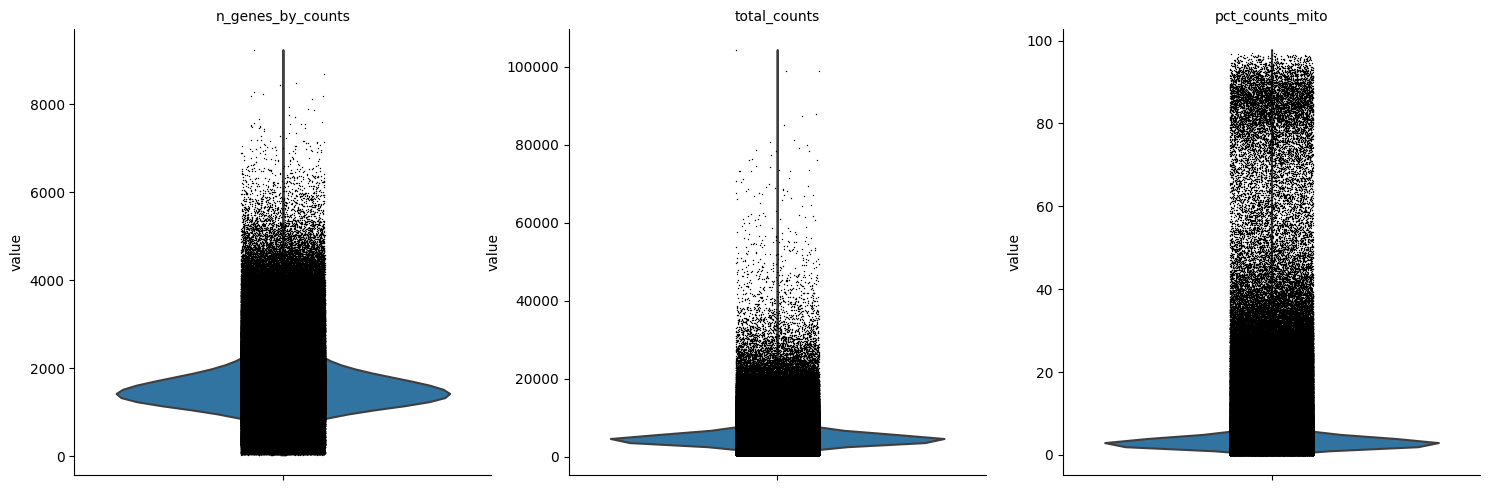

In [10]:
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],
    multi_panel = True
)

Remove cells with high mitochondrial fraction

In [11]:
mito_cut = 10

In [12]:
n_mito = sum(adata.obs["pct_counts_mito"] >= mito_cut)
perc_mito = round(n_mito / adata.shape[0] * 100, 2)

n_retain = adata.shape[0] - n_mito
perc_retain = round(n_retain / adata.shape[0] * 100, 2)

mito_message = 'Removing {n} High Mito = {p}%'.format(n = n_mito, p = perc_mito)
print(mito_message)
retain_message = 'Retaining {n} Low Mito = {p}%'.format(n = n_retain, p = perc_retain)
print(retain_message)

Removing 109940 High Mito = 5.32%
Retaining 1955231 Low Mito = 94.68%


In [13]:
adata = adata[(adata.obs["pct_counts_mito"] < mito_cut)]

Filter cells with low or abnormally high gene counts

In [14]:
low_cut = 200

In [15]:
n_low = sum(adata.obs["n_genes"] <= low_cut)
perc_low = round(n_low / adata.shape[0] * 100, 2)

n_retain = adata.shape[0] - n_low
perc_retain = round(n_retain / adata.shape[0] * 100, 2)

low_message = 'Removing {n} Low Gene Count = {p}%'.format(n = n_low, p = perc_low)
print(low_message)
retain_message = 'Retaining {n} Low Mito = {p}%'.format(n = n_retain, p = perc_retain)
print(retain_message)

Removing 1306 Low Gene Count = 0.07%
Retaining 1953925 Low Mito = 99.93%


In [16]:
adata = adata[adata.obs["n_genes"] > low_cut]

In [17]:
high_cut = 5000

In [18]:
n_high = sum(adata.obs["n_genes"] >= high_cut)
perc_high = round(n_high / adata.shape[0] * 100, 2)

n_retain = adata.shape[0] - n_high
perc_retain = round(n_retain / adata.shape[0] * 100, 2)

high_message = 'Removing {n} High Mito = {p}%'.format(n = n_high, p = perc_high)
print(high_message)
retain_message = 'Retaining {n} Low Mito = {p}%'.format(n = n_retain, p = perc_retain)
print(retain_message)

Removing 1797 High Mito = 0.09%
Retaining 1952128 Low Mito = 99.91%


In [19]:
adata = adata[adata.obs["n_genes"] < high_cut]

In [20]:
n_removed = n_start - adata.shape[0]
perc_removed = round(n_removed / n_start * 100, 2)

n_retain = adata.shape[0]
perc_retain = round(n_retain / n_start * 100, 2)

total_message = 'Removed {n} in Total = {p}%'.format(n = n_removed, p = perc_removed)
print(total_message)
retain_message = 'Retaining {n} in Total = {p}%'.format(n = n_retain, p = perc_retain)
print(retain_message)

Removed 140950 in Total = 6.73%
Retaining 1952128 in Total = 93.27%


## Normalize data and harmonize across cohorts

Because we're interested in cell types, not age-associated variation in our reference, we'll use Harmony to remove variation associated with `cohort.cohortGuid`, which corresponds to the major age groups in our dataset: UP1 = Pediatric, BR1 = Young Adult, BR2 = Older Adult.

In [21]:
adata.raw = adata

In [22]:
sc.pp.normalize_total(adata, target_sum = 1e4)

In [23]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [24]:
adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

In [25]:
sc.pp.scale(adata)

In [26]:
%%time
sc.tl.pca(adata, svd_solver = 'arpack')

CPU times: user 48min 28s, sys: 16min 59s, total: 1h 5min 27s
Wall time: 2min 30s


In [27]:
%%time
sce.pp.harmony_integrate(
    adata, 
    'cohort.cohortGuid',
    max_iter_harmony = 20
)

2024-02-19 18:06:14,216 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-19 18:18:00,701 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-19 18:18:09,465 - harmonypy - INFO - Iteration 1 of 20
2024-02-19 18:33:22,619 - harmonypy - INFO - Iteration 2 of 20
2024-02-19 18:49:39,548 - harmonypy - INFO - Iteration 3 of 20
2024-02-19 19:04:38,934 - harmonypy - INFO - Iteration 4 of 20
2024-02-19 19:20:20,379 - harmonypy - INFO - Iteration 5 of 20
2024-02-19 19:36:15,926 - harmonypy - INFO - Converged after 5 iterations


CPU times: user 12h 21min 42s, sys: 13h 30min 44s, total: 1d 1h 52min 27s
Wall time: 1h 30min 2s


Find Nearest Neighbors and perform UMAP for visualization using harmonized PCs.

In [ ]:
%%time
sc.pp.neighbors(
    adata, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30
)

In [29]:
%%time
sc.tl.umap(adata)

CPU times: user 12h 5min 42s, sys: 2h 24min 25s, total: 14h 30min 8s
Wall time: 1h 17min 30s


## Save filtered data to disk

In [30]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [34]:
filtered_h5ad = 'output/ref_pbmc_filtered_{d}.h5ad'.format(d = date.today())
adata.write_h5ad(filtered_h5ad)

Perform Leiden clustering for use with identifying major cell classes and subsetting.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'seurat.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

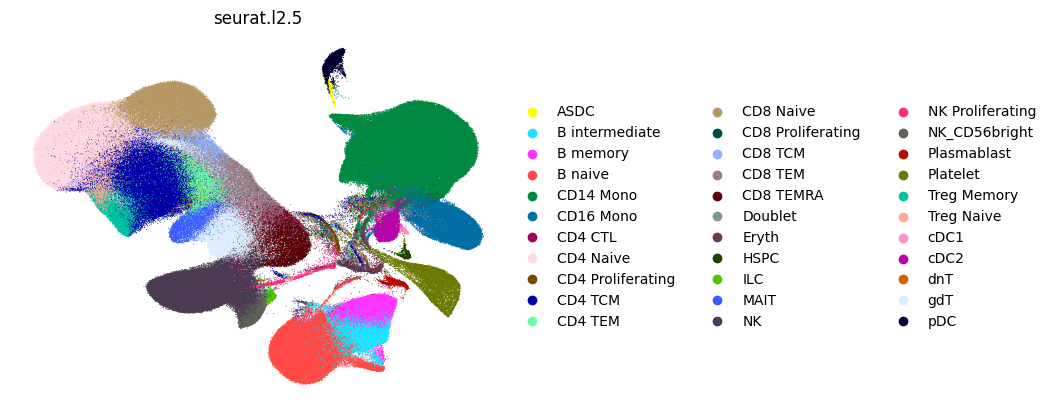

In [35]:
sc.pl.umap(
    adata, 
    color = ['seurat.l2.5'], 
    size = 2,
    show = False,
    ncols = 1,
    frameon = False
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'celltypist.low'}, xlabel='UMAP1', ylabel='UMAP2'>

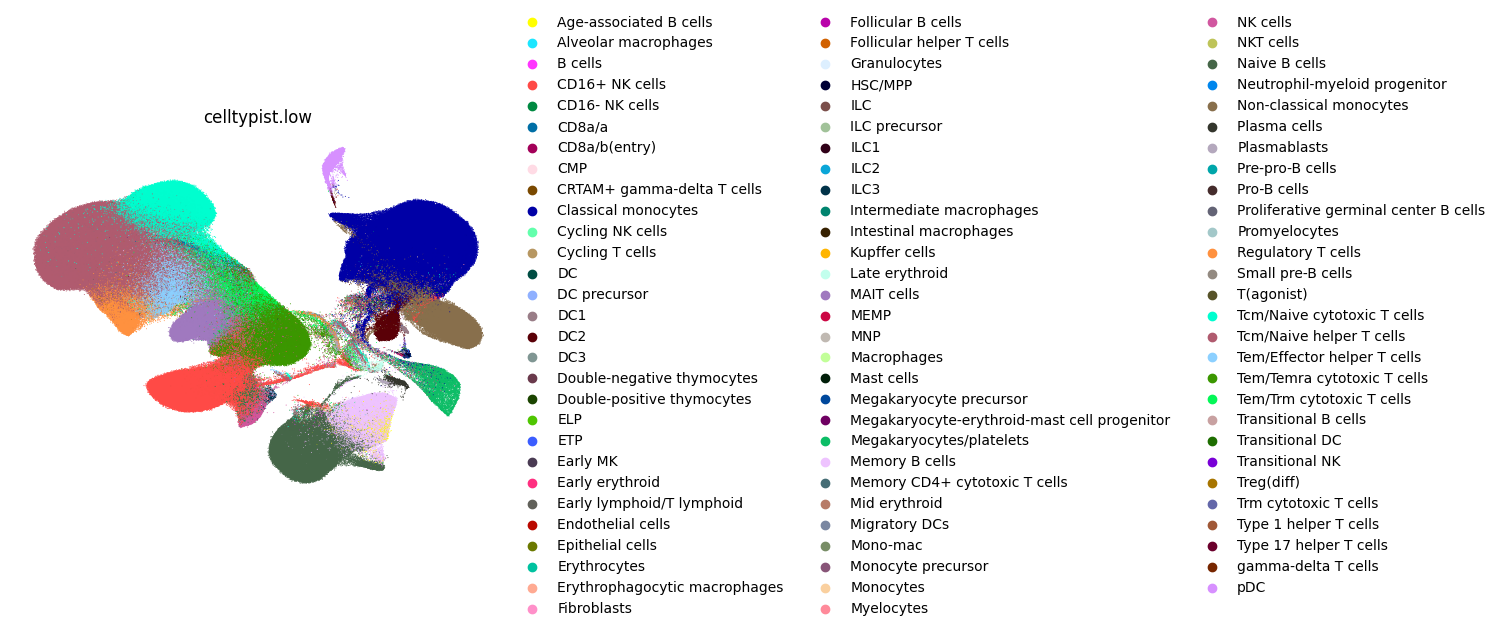

In [36]:
sc.pl.umap(
    adata, 
    color = ['celltypist.low'], 
    size = 2,
    show = False,
    ncols = 1,
    frameon = False
)

## Perform Leiden clustering

In [ ]:
sc.tl.leiden(adata)

Note: Leiden clustering took ~24hr

## Save clustered data to disk

Save clustered AnnData object to .h5ad

In [ ]:
clustered_h5ad = 'output/ref_pbmc_clustered_{d}.h5ad'.format(d = date.today())
adata.write_h5ad(clustered_h5ad)

## Preview clusters

In [13]:
out_files = os.listdir('output')
clustered_h5ad = list(filter(lambda f: 'clustered' in f, out_files))[0]

In [18]:
adata = sc.read_h5ad('output/' + clustered_h5ad)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

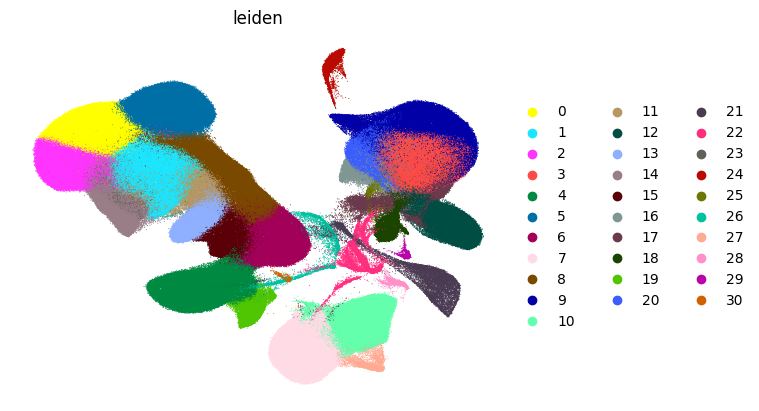

In [19]:
sc.pl.umap(
    adata, 
    color = ['leiden'], 
    size = 2,
    show = False,
    ncols = 1 ,
    frameon = False
)

In [24]:
umap_mat = adata.obsm['X_umap']

In [32]:
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

In [43]:
obs = adata.obs
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [39]:
out_csv = 'output/ref_pbmc_clustered_umap_meta_{d}.csv'.format(d = date.today())

In [ ]:
obs.to_csv(out_csv)

In [44]:
out_parquet = 'output/ref_pbmc_clustered_umap_meta_{d}.parquet'.format(d = date.today())

In [45]:
obs = obs.to_parquet(out_parquet)

## Upload assembled data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [46]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Clustered PBMC .h5ad {d}'.format(d = date.today())

In [49]:
in_files = [h5ad_uuid]

In [53]:
out_files = ['output/' + clustered_h5ad, out_csv, out_parquet]

In [54]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

you are trying to upload file_ids... ['output/ref_pbmc_clustered_2024-02-20.h5ad', 'output/ref_pbmc_clustered_umap_meta_2024-02-20.csv', 'output/ref_pbmc_clustered_umap_meta_2024-02-20.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'dff21171-2134-4de1-9126-3917d98b2541',
 'files': ['output/ref_pbmc_clustered_2024-02-20.h5ad',
  'output/ref_pbmc_clustered_umap_meta_2024-02-20.csv',
  'output/ref_pbmc_clustered_umap_meta_2024-02-20.parquet']}

In [55]:
import session_info
session_info.show()